### Importação dos dados .mat

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
from scipy.io import loadmat
train = loadmat('./Dados/dados_treinamento.mat')
val = loadmat('./Dados/dados_val.mat')
test = loadmat('./Dados/dados_teste.mat')

In [3]:
trainX = train['X']
trainY = train['y']
valX = val['Xval']
valY = val['yval']
testX = test['Xt']
testY = test['yt']

print ("trainX shape:\t ", trainX.shape)
print ("trainY shape:\t ", trainY.shape)
print ("valX shape:\t ", valX.shape)
print ("valY shape:\t ", valY.shape)
print ("testX shape:\t ", testX.shape)
print ("testY shape:\t ", testY.shape)

trainX shape:	  (1000, 2)
trainY shape:	  (1000, 1)
valX shape:	  (1000, 2)
valY shape:	  (1000, 1)
testX shape:	  (1000, 2)
testY shape:	  (1000, 1)


### Visualização do dataset

In [4]:
# dataset treino
train_df = pd.DataFrame(columns = ['x0', 'x1', 'y'])
train_df['x0'] = trainX[:,0]
train_df['x1'] = trainX[:,1]
train_df['y'] = trainY

# dataset validação
val_df = pd.DataFrame(columns = ['x0', 'x1', 'y'])
val_df['x0'] = valX[:,0]
val_df['x1'] = valX[:,1]
val_df['y'] = valY

# dataset teste
test_df = pd.DataFrame(columns = ['x0', 'x1', 'y'])
test_df['x0'] = testX[:,0]
test_df['x1'] = testX[:,1]
test_df['y'] = testY

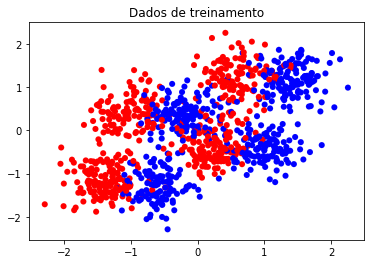

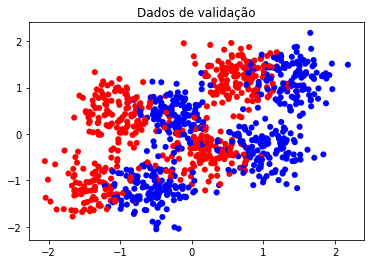

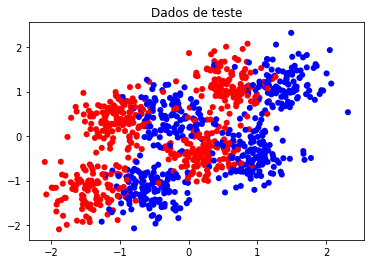

In [5]:
# treino
fig, ax = plt.subplots()
colors = {1 : 'blue', -1 : 'red'}
ax.scatter(train_df['x0'], train_df['x1'], c = train_df['y'].apply(lambda x: colors[x]), linewidth = 0.05)
plt.title("Dados de treinamento")
plt.show()

# validação
fig, ax = plt.subplots()
colors = {1 : 'blue', -1 : 'red'}
ax.scatter(val_df['x0'], val_df['x1'], c = val_df['y'].apply(lambda x: colors[x]), linewidth = 0.05)
plt.title("Dados de validação")
plt.show()

# teste
fig, ax = plt.subplots()
colors = {1 : 'blue', -1 : 'red'}
ax.scatter(test_df['x0'], test_df['x1'], c = test_df['y'].apply(lambda x: colors[x]), linewidth = 0.05)
plt.title("Dados de teste")
plt.show()

### Normalização dos dados
Como de praxe, pensei utilizar a técnica StandardScaler do tipo $\frac{(x-u)}{\sigma}$ para pré-processamento dos dados.
Entretanto, analisando estatisticamente o dataset (vide 3 tabelas abaixo) notei que os dados já vieram bem "mastigados", com média próxima de zero e desvio padrão. Neste sentido, não há vantagens em aplicar mais uma camada de normalização 

In [6]:
train_df.describe()

,x0,x1,y
count,1000.000000,1000.000000,1000.0000
mean,-0.016506,-0.016793,-0.0200
std,0.976396,0.976349,1.0003
min,-2.290398,-2.290398,-1.0000
25%,-0.776719,-0.776719,-1.0000
50%,-0.019674,-0.019674,-1.0000
75%,0.770224,0.770224,1.0000
max,2.254728,2.254728,1.0000


In [7]:
val_df.describe()

,x0,x1,y
count,1000.000000,1000.000000,1000.000000
mean,0.062321,0.063700,0.038000
std,0.944107,0.943006,0.999778
min,-2.052424,-2.052424,-1.000000
25%,-0.728216,-0.727800,-1.000000
50%,0.060793,0.060793,1.000000
75%,0.849111,0.849111,1.000000
max,2.179347,2.179347,1.000000


In [8]:
test_df.describe()

,x0,x1,y
count,1000.000000,1000.000000,1000.000000
mean,-0.015111,-0.014789,0.002000
std,0.942958,0.942908,1.000498
min,-2.092731,-2.092731,-1.000000
25%,-0.800184,-0.800184,-1.000000
50%,-0.009416,-0.008302,1.000000
75%,0.768194,0.768194,1.000000
max,2.317667,2.317667,1.000000


In [9]:
def acuracia(y, ŷ):
    ''' Retorna a acurácia (em %) do classificador'''
    acertos = 0
    erros = 0
    for i in range(len(y)):
        if y[i] == ŷ[i]:
            acertos += 1
        else:
            erros += 1
            
    return 100*(acertos)/(acertos + erros)

### Treinamento do modelo com MLP Classifier

<div>
<img src="./Imagens/neural_network.png" width="250"/>
</div>


- __função custo__:
    - log-loss (entropia cruzada)
- __função de ativação__:
    - __relu__ e __tanh__ apresentaram os melhores resultados. Entretanto, relu foi mais performático, chegando à tolerância com menor (praticamente, metade) número de iterações que o tanh
    - __logistic__ não apresentou bons resultados em comparação ao relu e tanh
- __passo de aprendizado__:
    - para o treinamento desta rede, utilizou-se o modelo de passo adaptativo. Neste caso, observa-se a variação da função custo, caso duas eṕocas de aprendizado não diminua a função custo por um delta de tolerência, o passo de aprendizado é atualizado como 1/5 do passo atual
    - a rede foi iniciada com passo inicial = 0.01
- __mini-batch__:
    - foi realizado um mini-batch para treinamento da rede. A cada 200 épocas o vetor de pesos era atualizado


In [10]:
from sklearn.neural_network import MLPClassifier

n = 10 # número de neurônios da camada intermediária
_hidden_layers_sizes = (n) # uma única camada intermediária com n neurônios
_activation = 'relu' # ‘identity’, ‘logistic’, ‘tanh’, ‘relu’ (funções de ativação)
_solver = 'sgd' # ‘lbfgs’, ‘sgd’, ‘adam’
_learning_rate = 'adaptive' # ‘constant’, ‘invscaling’, ‘adaptive’
_learning_rate_init = 0.01 # only used when solver=’sgd’ or ‘adam
_max_iter = 300000
_random_state = 0
_tol = 1e-6
_alpha = 0.0001 # parâmetro de regularização. deixado 0 para avaliação de overfitting do modelo
_verbose = False

classifier = MLPClassifier(hidden_layer_sizes = _hidden_layers_sizes,\
                           max_iter = _max_iter,\
                           activation = _activation,\
                           solver = _solver,\
                           random_state = None,\
                           learning_rate_init = _learning_rate_init,\
                           learning_rate = _learning_rate,\
                           tol = _tol,
                           verbose = _verbose,
                           alpha = _alpha)

#Fitting the training data to the network
classifier.fit(trainX, trainY.ravel())
loss_values_train = classifier.loss_curve_

#Fitting the validation data to the network
classifier.fit(valX, valY.ravel())
loss_values_val = classifier.loss_curve_

#Predicting y
ŷ = classifier.predict(trainX)

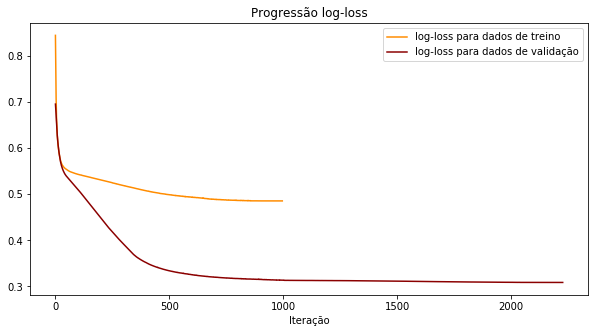

In [11]:
import matplotlib.pyplot as plt
plt.figure(figsize = (10, 5))
plt.xlabel('Iteração')
plt.title("Progressão log-loss")
plt.plot(loss_values_train, color = "darkorange", label = "log-loss para dados de treino")
plt.plot(loss_values_val, color = "darkred", label = "log-loss para dados de validação")
plt.legend()

### Matriz de confusão

In [12]:
#Importing Confusion Matrix
from sklearn.metrics import confusion_matrix

#Comparing the predictions against the actual observations in y_val
cm = confusion_matrix(ŷ, trainY)

#Printing cm
print("confusion matrix :\n", (cm))
#Printing accuracy
print("accuracy: ", 100*(cm.trace())/(cm.sum()))

confusion matrix :
 [[446  58]
 [ 64 432]]
accuracy:  87.8


### Plot da região de decisão do modelo com 10 neurônios

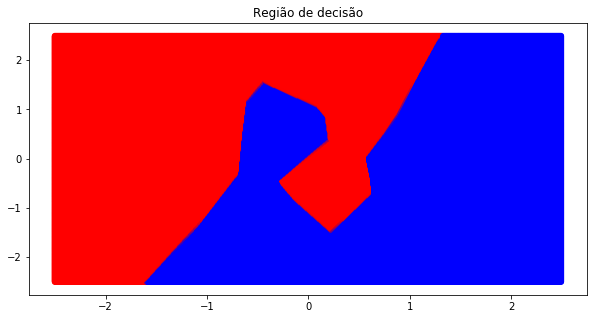

In [13]:
# gera todos pontos para serem avaliados pelo modelo
x0 = []
x1 = []
predicted = []
for i in np.arange(-2.5, 2.5, 0.01):
    for j in np.arange(-2.5, 2.5, 0.01):
        x0.append(i)
        x1.append(j)
        value = np.array([[i],[j]])
        y_pred = classifier.predict(value.T)
        predicted.append(y_pred)

# plot da região de decisão
fig, ax = plt.subplots(figsize = (10, 5))
colors = []
for value in predicted:
    if value == 1:
        colors.append('blue')
    else:
        colors.append('red')
        
ax.scatter(x0, x1, c = colors, linewidth = 0.05)
plt.title("Região de decisão")
plt.show()

### Treinando modelo para valores maiores de neurônios na camada intermediária

In [14]:
neuronios = range(1, 101)

train_errors = []
val_errors = []
test_errors = []

_activation = 'relu' # ‘identity’, ‘logistic’, ‘tanh’, ‘relu’
_solver = 'sgd' # ‘lbfgs’, ‘sgd’, ‘adam’
_learning_rate = 'adaptive' # ‘constant’, ‘invscaling’, ‘adaptive’
_learning_rate_init = 0.01 # only used when solver=’sgd’ or ‘adam
_max_iter = 300000
_random_state = 0
_tol = 1e-6
_verbose = False
_alpha = 0 # parâmetro de regularização. deixado 0 para avaliação de overfitting do modelo

for n in neuronios:
    _hidden_layers_sizes = (n) # uma única camada intermediária com n neurônios



    classifier2 = MLPClassifier(hidden_layer_sizes = _hidden_layers_sizes,\
                               max_iter = _max_iter,\
                               activation = _activation,\
                               solver = _solver,\
                               random_state = None,\
                               learning_rate_init = _learning_rate_init,\
                               learning_rate = _learning_rate,\
                               tol = _tol,
                               verbose = _verbose,
                               alpha = _alpha)

    #Fitting the training data to the network
    classifier2.fit(trainX, trainY.ravel())
    loss_values_train = classifier2.loss_curve_


    #Predicting y
    train_ŷ = classifier2.predict(trainX)
    val_ŷ = classifier2.predict(valX)
    test_ŷ = classifier2.predict(testX)
    
    # evaluation ŷ
    train_acu = acuracia(train_ŷ, trainY)
    train_errors.append(train_acu)
    val_acu = acuracia(val_ŷ, valY)
    val_errors.append(val_acu)
    test_acu = acuracia(test_ŷ, testY)
    test_errors.append(test_acu)


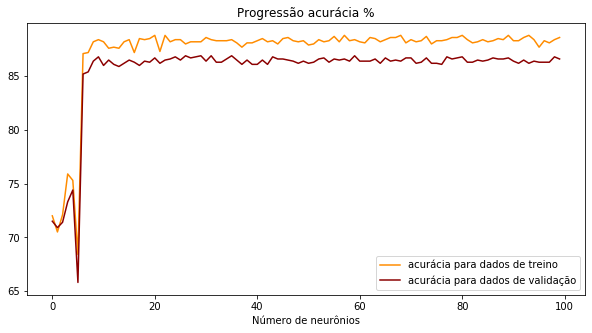

In [15]:
import matplotlib.pyplot as plt
plt.figure(figsize = (10, 5))
plt.xlabel('Número de neurônios')
plt.title("Progressão acurácia %")
plt.plot(train_errors, color = "darkorange", label = "acurácia para dados de treino")
plt.plot(val_errors, color = "darkred", label = "acurácia para dados de validação")
#plt.plot(test_errors, color = "darkgreen", label = "acurácia para dados de teste")
plt.legend()

### Comentários a respeito do aumento do número de neurônios
- como pode se ver pelo gráfico acima, o aumento do número de neurônios tem um perfil de saturação, ou seja, a partir de certo valor de número de neurônios, a acurácia do modelo deixa de ter seu valor aumentado, o que não é desejável, uma vez que o aumento do número do neurônios torna o problema mais complexo do ponto de vista computacional